In [46]:
!pip install -U sentence-transformers
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [47]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from etf_transformations import *


In [48]:
base_data = pd.read_csv("../data/preprocessed/base_dataset_news.csv")
base_data.head(2)

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,negative,finbert_label,finbert_confidence,avg_positive_global,avg_neutral_global,avg_negative_global,n_headlines,sent_index_global,is_trading_day
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,0.011696,neutral,0.606314,0.186842,0.466275,0.346883,81,-0.160042,1
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,0.662610,negative,0.662610,0.186842,0.466275,0.346883,81,-0.160042,1


In [49]:
base_data['row_id'] = base_data.index
base_data.head()

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,negative,finbert_label,finbert_confidence,avg_positive_global,avg_neutral_global,avg_negative_global,n_headlines,sent_index_global,is_trading_day,row_id
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,0.011696,neutral,0.606314,0.186842,0.466275,0.346883,81,-0.160042,1,0
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,0.662610,negative,0.662610,0.186842,0.466275,0.346883,81,-0.160042,1,1
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0,0.018125,0.884106,0.097769,neutral,0.884106,0.186842,0.466275,0.346883,81,-0.160042,1,2
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0,0.032822,0.651042,0.316137,neutral,0.651042,0.186842,0.466275,0.346883,81,-0.160042,1,3
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1,0.038724,0.937915,0.023361,neutral,0.937915,0.186842,0.466275,0.346883,81,-0.160042,1,4


In [50]:
base_data.columns

Index(['Date', 'Headlines', 'Newspaper', 'XLE', 'XLF', 'XLK', 'XLV', 'XLY',
       'positive', 'neutral', 'negative', 'finbert_label',
       'finbert_confidence', 'avg_positive_global', 'avg_neutral_global',
       'avg_negative_global', 'n_headlines', 'sent_index_global',
       'is_trading_day', 'row_id'],
      dtype='object')

In [51]:
base_data.nunique()

Date                     851
Headlines              50919
Newspaper                  3
XLE                        2
XLF                        2
XLK                        2
XLV                        2
XLY                        2
positive               50919
neutral                50863
negative               50828
finbert_label              3
finbert_confidence     50549
avg_positive_global      851
avg_neutral_global       851
avg_negative_global      851
n_headlines              130
sent_index_global        851
is_trading_day             2
row_id                 51122
dtype: int64

In [52]:
# mini test from the transformers website

sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings, embeddings.shape)

[[ 6.76568747e-02  6.34959713e-02  4.87131178e-02  7.93049708e-02
   3.74480747e-02  2.65281973e-03  3.93749960e-02 -7.09845219e-03
   5.93613535e-02  3.15370485e-02  6.00980595e-02 -5.29052056e-02
   4.06067446e-02 -2.59308629e-02  2.98428200e-02  1.12690695e-03
   7.35148489e-02 -5.03818318e-02 -1.22386657e-01  2.37028580e-02
   2.97265369e-02  4.24768478e-02  2.56337859e-02  1.99512066e-03
  -5.69190606e-02 -2.71597914e-02 -3.29035483e-02  6.60248324e-02
   1.19007185e-01 -4.58791144e-02 -7.26214498e-02 -3.25839706e-02
   5.23413457e-02  4.50553186e-02  8.25298484e-03  3.67024355e-02
  -1.39415739e-02  6.53918087e-02 -2.64272038e-02  2.06389377e-04
  -1.36643564e-02 -3.62810530e-02 -1.95043888e-02 -2.89737973e-02
   3.94270085e-02 -8.84090886e-02  2.62424443e-03  1.36713777e-02
   4.83062193e-02 -3.11566442e-02 -1.17329180e-01 -5.11690341e-02
  -8.85287598e-02 -2.18963176e-02  1.42986597e-02  4.44167666e-02
  -1.34815862e-02  7.43392333e-02  2.66382825e-02 -1.98762845e-02
   1.79191

In [53]:
sentences = base_data["Headlines"].astype(str).tolist()

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = model.encode(
    sentences,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)


Batches:   0%|          | 0/799 [00:00<?, ?it/s]

In [54]:
embeddings_as_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])

In [55]:
embeddings_as_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,-0.027789,-0.077502,-0.023243,0.001279,0.105400,0.062750,0.026079,-0.040449,-0.032805,-0.024077,...,0.085011,-0.048258,-0.054372,-0.046042,-0.058606,-0.016788,0.004511,-0.123710,0.027060,0.097270
1,-0.047038,-0.058779,0.039020,-0.022604,0.040275,0.020005,0.078715,-0.011565,-0.051720,-0.062584,...,0.066003,0.030541,-0.024649,-0.044539,-0.018354,-0.018619,0.003425,-0.027990,-0.001139,-0.002184
2,-0.027929,0.057069,-0.030522,0.040231,0.009958,-0.033024,0.004027,-0.128492,-0.052365,0.029087,...,-0.019214,0.047262,-0.019467,0.056820,0.032496,0.017863,0.107006,-0.092001,-0.023388,-0.012118
3,-0.010858,0.002384,0.053087,-0.034931,0.084241,-0.038906,-0.002872,-0.061852,-0.020340,0.000921,...,-0.008723,-0.009251,0.048255,0.079781,-0.097413,-0.071449,0.053479,-0.088406,0.024191,-0.039716
4,0.001041,-0.015856,-0.033049,-0.048611,0.033087,0.019332,-0.025710,-0.034395,0.033880,-0.072620,...,0.058902,-0.006282,-0.009820,-0.062463,0.025669,0.082309,0.057419,-0.089949,0.036099,0.055160


In [56]:
i, j = 0,1  # indeksy w df

v1 = embeddings_as_df.loc[i, [c for c in embeddings_as_df.columns if c.startswith("emb_")]].values.reshape(1, -1)
v2 = embeddings_as_df.loc[j, [c for c in embeddings_as_df.columns if c.startswith("emb_")]].values.reshape(1, -1)

cosine_similarity(v1, v2)[0, 0]


0.3763337

Merging the base df with news headlines with the df with embeddings.


In [57]:
embeddings_as_df["row_id"] = base_data["row_id"].values

In [58]:
is_trading_day_column(base_data)

In [59]:
news_df = base_data.merge(embeddings_as_df, on='row_id', how="left", validate='1:1')

In [60]:
news_df

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,...,0.085011,-0.048258,-0.054372,-0.046042,-0.058606,-0.016788,0.004511,-0.123710,0.027060,0.097270
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,...,0.066003,0.030541,-0.024649,-0.044539,-0.018354,-0.018619,0.003425,-0.027990,-0.001139,-0.002184
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0,0.018125,0.884106,...,-0.019214,0.047262,-0.019467,0.056820,0.032496,0.017863,0.107006,-0.092001,-0.023388,-0.012118
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0,0.032822,0.651042,...,-0.008723,-0.009251,0.048255,0.079781,-0.097413,-0.071449,0.053479,-0.088406,0.024191,-0.039716
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1,0.038724,0.937915,...,0.058902,-0.006282,-0.009820,-0.062463,0.025669,0.082309,0.057419,-0.089949,0.036099,0.055160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51117,2020-07-17,I flew the jumbo for 10 years and never got ov...,guardian,0,0,0,0,0,0.079837,0.899124,...,0.004520,0.035751,-0.059833,0.071211,-0.003427,-0.014488,-0.051172,0.054397,-0.101978,-0.011948
51118,2020-07-17,BA begins to carry out its 'fire and rehire' t...,guardian,0,0,0,0,0,0.025897,0.309608,...,0.007369,0.011398,-0.010782,-0.043422,-0.026654,0.007978,0.052454,-0.099890,0.017463,-0.011236
51119,2020-07-17,Johnson's coronavirus workplace guidance confu...,guardian,0,0,0,1,0,0.094602,0.661800,...,-0.038117,-0.018123,0.015808,-0.038996,-0.048658,-0.071643,0.003146,-0.098249,-0.013926,0.043069
51120,2020-07-17,Wall Street Week Ahead: Fund managers navigate...,reuters,0,0,0,0,0,0.045176,0.894620,...,0.058042,-0.002948,0.005600,0.084361,-0.118377,-0.019045,0.037833,-0.102337,-0.050522,0.062095


In [61]:
news_df.columns

Index(['Date', 'Headlines', 'Newspaper', 'XLE', 'XLF', 'XLK', 'XLV', 'XLY',
       'positive', 'neutral',
       ...
       'emb_374', 'emb_375', 'emb_376', 'emb_377', 'emb_378', 'emb_379',
       'emb_380', 'emb_381', 'emb_382', 'emb_383'],
      dtype='object', length=404)

In [62]:
news_df.to_csv("../data/preprocessed/final_data_with_embeddings_without_aggregations.csv", index=False)

In [3]:
base_data = pd.read_csv("../data/preprocessed/final_data_with_embeddings_without_aggregations.csv")

In [6]:
base_data.head()

,Date,Headlines,Newspaper,XLE,XLF,XLK,XLV,XLY,positive,neutral,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t...",cnbc,0,0,1,0,0,0.381990,0.606314,...,0.085011,-0.048258,-0.054372,-0.046042,-0.058606,-0.016788,0.004511,-0.123710,0.027060,0.097270
1,2018-03-20,G20 financial leaders say need more dialogue o...,reuters,0,0,0,0,0,0.259833,0.077557,...,0.066003,0.030541,-0.024649,-0.044539,-0.018354,-0.018619,0.003425,-0.027990,-0.001139,-0.002184
2,2018-03-20,Index provider MSCI says it is reviewing Faceb...,reuters,0,0,0,0,0,0.018125,0.884106,...,-0.019214,0.047262,-0.019467,0.056820,0.032496,0.017863,0.107006,-0.092001,-0.023388,-0.012118
3,2018-03-20,UK's Cambridge University questions Facebook a...,reuters,0,0,0,0,0,0.032822,0.651042,...,-0.008723,-0.009251,0.048255,0.079781,-0.097413,-0.071449,0.053479,-0.088406,0.024191,-0.039716
4,2018-03-20,"Exclusive: On Amazon, a quarter of merchants' ...",reuters,0,0,0,0,1,0.038724,0.937915,...,0.058902,-0.006282,-0.009820,-0.062463,0.025669,0.082309,0.057419,-0.089949,0.036099,0.055160


N rows: 51122
NaNs in finbert_confidence: 0 (0.00%)
Describe:
count    51122.000000
mean         0.806224
std          0.141974
min          0.336132
25%          0.715226
50%          0.854598
75%          0.921421
max          0.977274
Name: finbert_confidence, dtype: float64
Quantiles:
0.01    0.451488
0.05    0.519151
0.10    0.572676
0.25    0.715226
0.50    0.854598
0.75    0.921421
0.90    0.949419
0.95    0.961366
0.99    0.970877
Name: finbert_confidence, dtype: float64


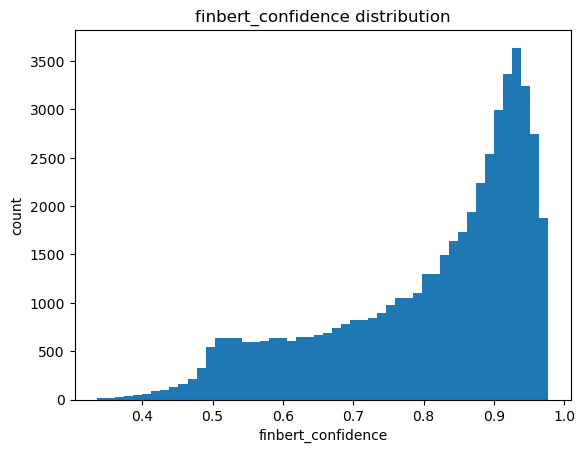

XLE
N headlines: 2720  NaNs: 0
Describe:
XLF
N headlines: 4357  NaNs: 0
Describe:
XLK
N headlines: 3006  NaNs: 0
Describe:
XLV
N headlines: 4119  NaNs: 0
Describe:
XLY
N headlines: 4809  NaNs: 0
Describe:


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

conf = base_data["finbert_confidence"].astype(float)

print("N rows:", len(base_data))
print("NaNs in finbert_confidence:", conf.isna().sum(), f"({conf.isna().mean():.2%})")
print("Describe:")
print(conf.describe())

print("Quantiles:")
print(conf.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]))


plt.figure()
plt.hist(conf.dropna().values, bins=50)
plt.title("finbert_confidence distribution")
plt.xlabel("finbert_confidence")
plt.ylabel("count")
plt.show()

sector_cols = [c for c in ["XLE","XLF","XLK","XLV","XLY"] if c in base_data.columns]

for s in sector_cols:
    c = base_data.loc[base_data[s] == 1, "finbert_confidence"].astype(float)
    if len(c.dropna()) == 0:
        print(f"\n{s}: no non-NaN confidence values")
        continue

    print(f"{s}")
    print("N headlines:", len(c), " NaNs:", c.isna().sum())
    print("Describe:")
